<a href="https://colab.research.google.com/github/darttusin/HSE-ML-Course/blob/main/notebooks/AI_HW4_woodenML_base_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 29 января 23:59

**Продуктивной и интересной вам работы!**

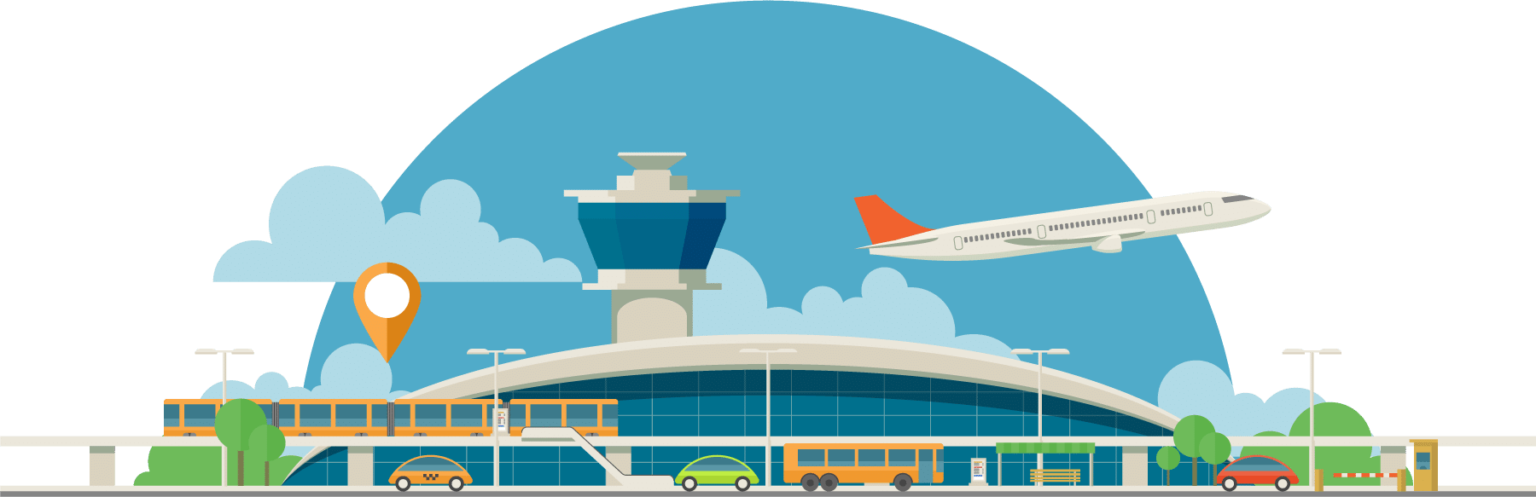

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: scikit-learn
    Found existing installation: s

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2bd9b21518f838013038986151e0fb993b1f2bf5f61f0a0e2e549ce94504743f
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 703.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.24.0 requires numpy>=2.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2026-01-31 17:15:30--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2026-01-31 17:15:31 (1.11 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

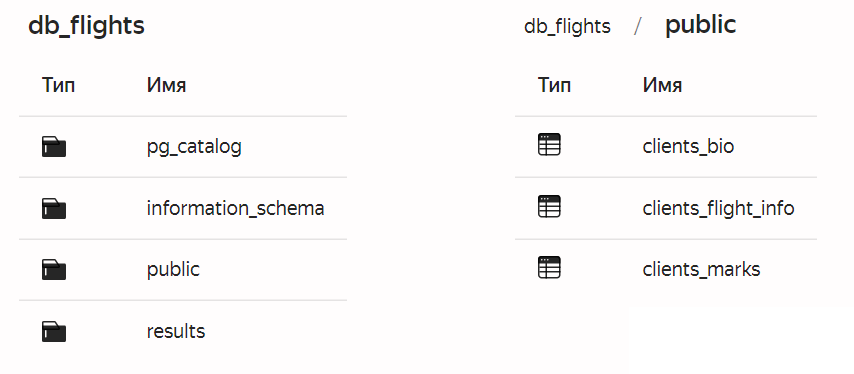



In [8]:
DB_PARAMS = {
    'host': 'rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'db_flights',
    'user': 'mlhs_student',
    'password': 'mlhs_student',
    'sslmode': 'verify-full',
    'target_session_attrs': 'read-write'
}

with psycopg2.connect(**DB_PARAMS) as conn, conn.cursor() as cursor:
  cursor.execute(
      """
      SELECT
        table_schema,
        table_name,
        table_type
      FROM information_schema.tables
      """
  )
  tables = cursor.fetchall()

In [13]:
with psycopg2.connect(**DB_PARAMS) as conn, conn.cursor() as cursor:
  for table in tables:
    if table[0] == "public":
      query = f"""
      SELECT
          column_name,
          data_type,
          is_nullable,
          ordinal_position
      FROM information_schema.columns
      WHERE table_schema = 'public'
          AND table_name = '{table[1]}'
      ORDER BY ordinal_position;
      """
      cursor.execute(query)
      print(table[1])
      print(cursor.fetchall())

student_predictions
[('index', 'bigint', 'YES', 1), ('id', 'bigint', 'YES', 2), ('prediction', 'bigint', 'YES', 3), ('surname', 'text', 'YES', 4)]
results.student_predictions
[('surname', 'text', 'YES', 1), ('id', 'bigint', 'YES', 2), ('prediction', 'bigint', 'YES', 3)]
clients_marks
[('id', 'integer', 'YES', 1), ('Inflight wifi service', 'text', 'YES', 2), ('Departure/Arrival time convenient', 'text', 'YES', 3), ('Ease of Online booking', 'text', 'YES', 4), ('Gate location', 'text', 'YES', 5), ('Food and drink', 'text', 'YES', 6), ('Online boarding', 'text', 'YES', 7), ('Seat comfort', 'text', 'YES', 8), ('Inflight entertainment', 'text', 'YES', 9), ('On-board service', 'text', 'YES', 10), ('Leg room service', 'text', 'YES', 11), ('Baggage handling', 'text', 'YES', 12), ('Checkin service', 'text', 'YES', 13), ('Inflight service', 'text', 'YES', 14), ('cleanliness', 'text', 'YES', 15), ('satisfaction', 'text', 'YES', 16)]
clients_flight_info
[('id', 'integer', 'YES', 1), ('Customer Typ

In [14]:
SQL_QUERY = """
SELECT
    cm.id,
    cm."Inflight wifi service",
    cm."Departure/Arrival time convenient",
    cm."Ease of Online booking",
    cm."Gate location",
    cm."Food and drink",
    cm."Online boarding",
    cm."Seat comfort",
    cm."Inflight entertainment",
    cm."On-board service",
    cm."Leg room service",
    cm."Baggage handling",
    cm."Checkin service",
    cm."Inflight service",
    cm.cleanliness,
    cm.satisfaction,
    cfi."Customer Type",
    cfi."Type of Travel",
    cfi.class,
    cfi."Flight Distance",
    cfi."Departure Delay in Minutes",
    cfi."Arrival Delay in Minutes",
    cb.gender,
    cb.age
FROM clients_marks cm
JOIN clients_flight_info cfi ON cm.id = cfi.id
JOIN clients_bio cb ON cm.id = cb.id
ORDER BY cm.id;
"""

In [15]:
with psycopg2.connect(**DB_PARAMS) as conn:
  df = pd.read_sql_query(SQL_QUERY, conn)

  df.set_index('id', inplace=True)

  print("\nПервые 3 строки:")
  print(df.head(3))

  df.to_csv('flight_data.csv')

/tmp/ipython-input-4060118513.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(SQL_QUERY, conn)



Первые 3 строки:
   Inflight wifi service Departure/Arrival time convenient  \
id                                                           
1                    3.0                               3.0   
2                    2.0                               2.0   
3                    4.0                               4.0   

   Ease of Online booking Gate location Food and drink Online boarding  \
id                                                                       
1                     3.0           3.0            5.0             3.0   
2                     2.0           2.0            3.0             5.0   
3                     4.0           4.0            5.0             5.0   

   Seat comfort Inflight entertainment On-board service Leg room service  ...  \
id                                                                        ...   
1           5.0                    5.0              3.0              2.0  ...   
2           4.0                    5.0              5.0  

In [16]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [20]:
pd.options.display.max_columns = 200

In [21]:
df

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
id,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0,4.0,5.0,5.0,neutral or dissatisfied,disloyal Customer,Business travel,Business,821.0,2.0,5.0,Male,48.0
2,2.0,2.0,2.0,2.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,satisfied,Loyal Customer,Business travel,Business,821.0,26.0,39.0,Female,35.0
3,4.0,4.0,4.0,4.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,5.0,satisfied,Loyal Customer,Business travel,Business,853.0,0.0,0.0,Male,41.0
4,2.0,2.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,satisfied,Loyal Customer,Business travel,Business,1905.0,0.0,0.0,Male,50.0
5,3.0,3.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,satisfied,Loyal Customer,Business travel,Business,3470.0,0.0,1.0,Female,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129876,4.0,4.0,4.0,2.0,4.0,4.0,1.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,-,Loyal Customer,Personal Travel,Eco Plus,447.0,2.0,3.0,Male,28.0
129877,3.0,5.0,3.0,4.0,2.0,3.0,2.0,2.0,5.0,5.0,5.0,5.0,nan,2.0,-,Loyal Customer,Personal Travel,Eco Plus,308.0,0.0,0.0,Male,41.0
129878,2.0,5.0,2.0,1.0,3.0,2.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,3.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco Plus,337.0,6.0,14.0,Male,42.0


In [22]:
df.describe()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
count,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549,129549
unique,23,24,24,24,25,22,22,22,21,26,23,23,27,22,3,3,3,4,4058,522,533,2,264
top,2.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,neutral or dissatisfied,Loyal Customer,Business travel,Business,337.0,0.0,0.0,Female,39.0
freq,32220,31779,30292,35594,30474,38353,39641,36693,38582,35775,46621,36222,47157,33877,58732,105763,89405,61939,837,73090,72489,65726,3653


In [23]:
numerical_cols = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness',
    'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'age'
]

In [24]:
df[numerical_cols] = df[numerical_cols].astype(float)

In [25]:
print(df.isnull().sum())

Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
gender                                 0
age                                  315
dtype: int64


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

/tmp/ipython-input-633616890.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

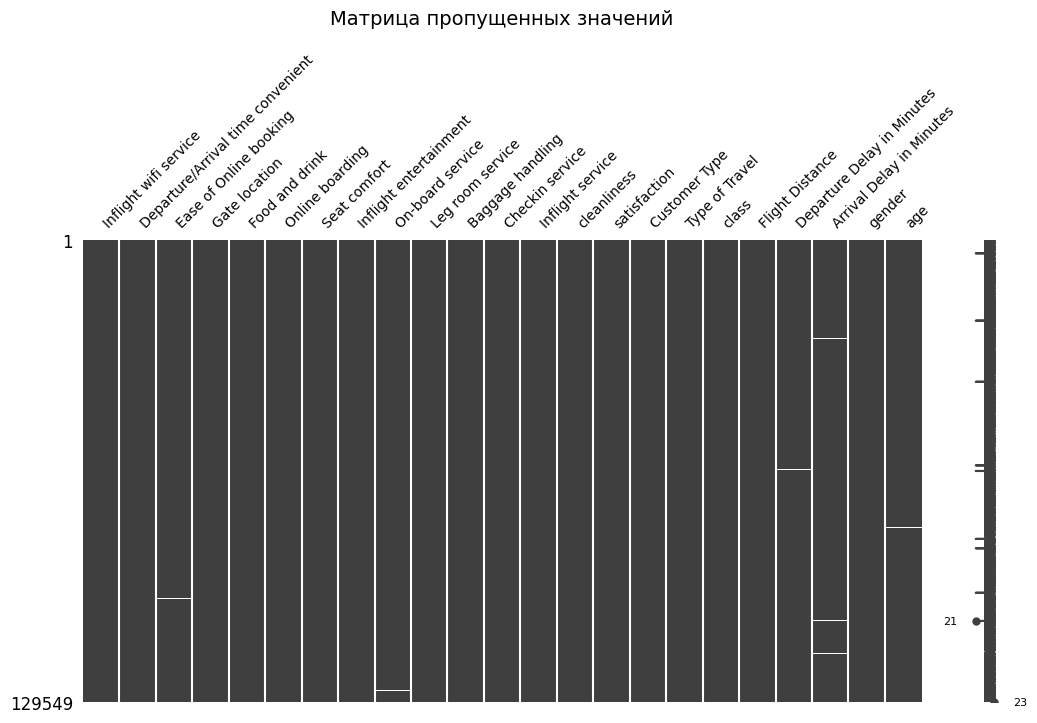

In [31]:
plt.figure(figsize=(12, 6))
missingno.matrix(df, figsize=(12, 6), fontsize=10)
plt.title('Матрица пропущенных значений', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

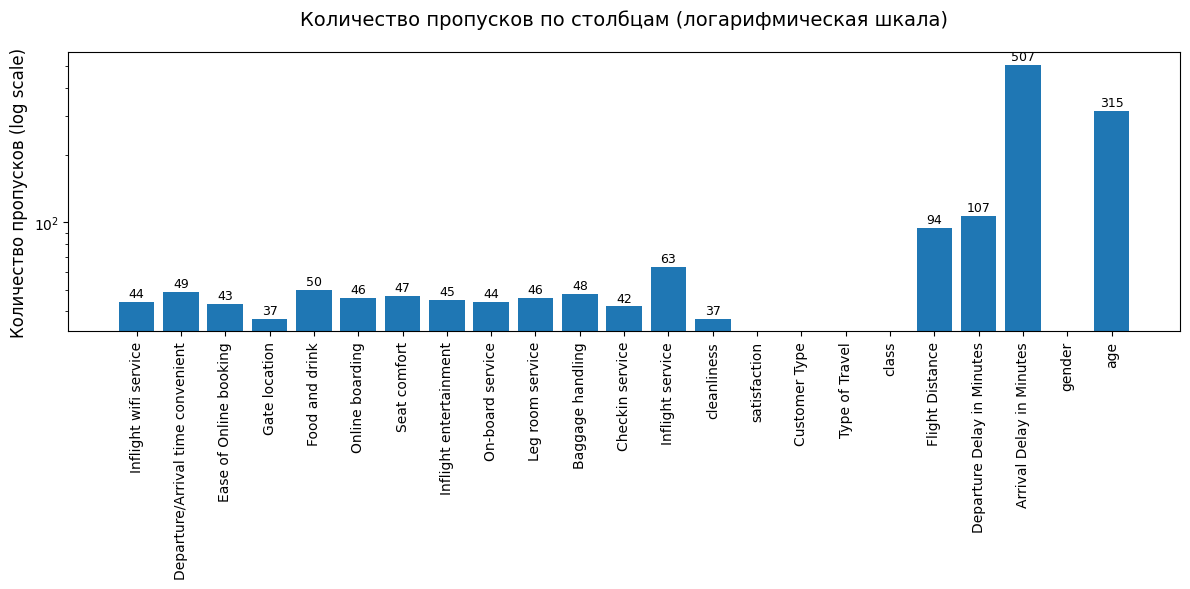

In [32]:
plt.figure(figsize=(12, 6))

missing_counts = df.isnull().sum()

bars = plt.bar(missing_counts.index, missing_counts.values)
plt.yscale('log')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Количество пропусков по столбцам (логарифмическая шкала)', fontsize=14, pad=20)
plt.ylabel('Количество пропусков (log scale)', fontsize=12)

for bar, count in zip(bars, missing_counts.values):
    if count > 0:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 1.02,
                f'{count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [33]:
df_train = df[df.satisfaction != '-']
df_train

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
id,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0,4.0,5.0,5.0,neutral or dissatisfied,disloyal Customer,Business travel,Business,821.0,2.0,5.0,Male,48.0
2,2.0,2.0,2.0,2.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,satisfied,Loyal Customer,Business travel,Business,821.0,26.0,39.0,Female,35.0
3,4.0,4.0,4.0,4.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,5.0,satisfied,Loyal Customer,Business travel,Business,853.0,0.0,0.0,Male,41.0
4,2.0,2.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,satisfied,Loyal Customer,Business travel,Business,1905.0,0.0,0.0,Male,50.0
5,3.0,3.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,satisfied,Loyal Customer,Business travel,Business,3470.0,0.0,1.0,Female,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,4.0,2.0,4.0,4.0,3.0,4.0,3.0,3.0,1.0,5.0,3.0,4.0,4.0,3.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco Plus,337.0,0.0,0.0,Female,28.0
129875,3.0,4.0,3.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco Plus,308.0,0.0,0.0,Female,55.0
129878,2.0,5.0,2.0,1.0,3.0,2.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,3.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco Plus,337.0,6.0,14.0,Male,42.0


In [34]:
assert df_train.shape == (103_644, 23)

In [35]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
id,,,,,,,,,,,,,,,,,,,,,,
17,2.0,3.0,2.0,3.0,1.0,5.0,1.0,5.0,5.0,2.0,5.0,5.0,5.0,2.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,Female,48.0
20,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,Loyal Customer,Personal Travel,Eco,821.0,4.0,0.0,Female,42.0
35,2.0,2.0,2.0,2.0,5.0,4.0,5.0,3.0,3.0,4.0,5.0,5.0,3.0,5.0,Loyal Customer,Business travel,Business,1672.0,23.0,17.0,Male,39.0
44,4.0,1.0,4.0,4.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,Loyal Customer,Business travel,Business,2077.0,0.0,1.0,Male,51.0
49,4.0,5.0,4.0,1.0,5.0,4.0,3.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,disloyal Customer,Business travel,Eco,108.0,0.0,29.0,Male,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129847,0.0,4.0,0.0,5.0,3.0,0.0,3.0,3.0,5.0,2.0,4.0,4.0,5.0,3.0,Loyal Customer,Personal Travel,Eco,337.0,0.0,0.0,Female,16.0
129868,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,2.0,5.0,3.0,1.0,4.0,4.0,Loyal Customer,Business travel,Eco Plus,447.0,0.0,0.0,Male,47.0
129872,4.0,2.0,4.0,2.0,4.0,4.0,4.0,4.0,5.0,1.0,3.0,5.0,1.0,4.0,Loyal Customer,Business travel,Eco Plus,337.0,0.0,1.0,Female,32.0


In [36]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [37]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [38]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [39]:
categorical_cols = ['Customer Type', 'Type of Travel', 'class', 'gender']

In [40]:
for col in numerical_cols:
    if col in X_train.columns:
        mode_val = X_train[col].mode()[0]

        X_train[col] = X_train[col].fillna(mode_val)
        X_val[col] = X_val[col].fillna(mode_val)
        if col in df_test.columns:
            df_test[col] = df_test[col].fillna(mode_val)

In [41]:
for col in categorical_cols:
    if col in X_train.columns:
        mode_val = X_train[col].mode()[0]

        X_train[col] = X_train[col].fillna(mode_val)
        X_val[col] = X_val[col].fillna(mode_val)
        if col in df_test.columns:
            df_test[col] = df_test[col].fillna(mode_val)

In [42]:
print("Пропуски в X_train после заполнения:", X_train.isnull().sum().sum())
print("Пропуски в X_val после заполнения:", X_val.isnull().sum().sum())
print("Пропуски в df_test после заполнения:", df_test.isnull().sum().sum())

Пропуски в X_train после заполнения: 0
Пропуски в X_val после заполнения: 0
Пропуски в df_test после заполнения: 0


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [43]:
train_data = X_train.copy()
train_data['satisfaction'] = y_train

In [45]:
service_cols = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness'
]

other_numeric = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'age']

In [47]:
print("\n1. СЕРВИСНЫЕ ОЦЕНКИ:")
for col in service_cols:
    if col in train_data.columns:
        stats = train_data[col].describe()
        print(f"\n{col}:")
        print(f"  Среднее: {stats['mean']:.2f}, Медиана: {stats['50%']:.2f}")
        print(f"  Min: {stats['min']:.0f}, Max: {stats['max']:.0f}")
        print(f"  Стандартное отклонение: {stats['std']:.2f}")

print("\n2. ДРУГИЕ ЧИСЛОВЫЕ ПРИЗНАКИ:")
for col in other_numeric:
    if col in train_data.columns:
        stats = train_data[col].describe()
        print(f"\n{col}:")
        print(f"  Среднее: {stats['mean']:.2f}, Медиана: {stats['50%']:.2f}")
        print(f"  Min: {stats['min']:.0f}, Max: {stats['max']:.0f}")
        print(f"  Стандартное отклонение: {stats['std']:.2f}")

print("\n3. КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
categorical_cols = ['Customer Type', 'Type of Travel', 'class', 'gender', 'satisfaction']

for col in categorical_cols:
    if col in train_data.columns:
        value_counts = train_data[col].value_counts(normalize=True) * 100
        print(f"\n{col}:")
        print(f"  Уникальных значений: {train_data[col].nunique()}")
        for val, perc in value_counts.items():
            print(f"  {val}: {perc:.1f}%")


1. СЕРВИСНЫЕ ОЦЕНКИ:

Inflight wifi service:
  Среднее: 2.74, Медиана: 3.00
  Min: 0, Max: 45
  Стандартное отклонение: 1.37

Departure/Arrival time convenient:
  Среднее: 3.06, Медиана: 3.00
  Min: 0, Max: 45
  Стандартное отклонение: 1.56

Ease of Online booking:
  Среднее: 2.76, Медиана: 3.00
  Min: 0, Max: 36
  Стандартное отклонение: 1.42

Gate location:
  Среднее: 2.98, Медиана: 3.00
  Min: 0, Max: 36
  Стандартное отклонение: 1.30

Food and drink:
  Среднее: 3.21, Медиана: 3.00
  Min: 0, Max: 45
  Стандартное отклонение: 1.36

Online boarding:
  Среднее: 3.26, Медиана: 3.00
  Min: 0, Max: 40
  Стандартное отклонение: 1.39

Seat comfort:
  Среднее: 3.44, Медиана: 4.00
  Min: 0, Max: 36
  Стандартное отклонение: 1.34

Inflight entertainment:
  Среднее: 3.36, Медиана: 4.00
  Min: 0, Max: 40
  Стандартное отклонение: 1.37

On-board service:
  Среднее: 3.38, Медиана: 4.00
  Min: 0, Max: 45
  Стандартное отклонение: 1.33

Leg room service:
  Среднее: 3.36, Медиана: 4.00
  Min: 0, Max

Данные содержат экстремальные выбросы в числовых признаках. Наблюдается дисбаланс классов в целевой переменной.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [49]:
original_train_size = len(X_train)
original_val_size = len(X_val)

def remove_outliers(df, numeric_cols):
    outlier_mask = pd.Series(False, index=df.index)

    for col in numeric_cols:
        if col in df.columns:
            threshold = df[col].quantile(0.996)
            outlier_mask = outlier_mask | (df[col] > threshold)

    df_clean = df[~outlier_mask].copy()
    return df_clean, outlier_mask.sum()

X_train_clean, train_outliers = remove_outliers(X_train, numerical_cols)
X_val_clean, val_outliers = remove_outliers(X_val, numerical_cols)

y_train_clean = y_train.loc[X_train_clean.index]
y_val_clean = y_val.loc[X_val_clean.index]

print(f"Исходный размер X_train: {original_train_size}")
print(f"Удалено строк с выбросами в X_train: {train_outliers}")
print(f"Размер X_train после удаления выбросов: {len(X_train_clean)}")
print(f"Процент удаленных строк: {train_outliers/original_train_size*100:.2f}%")
print()
print(f"Исходный размер X_val: {original_val_size}")
print(f"Удалено строк с выбросами в X_val: {val_outliers}")
print(f"Размер X_val после удаления выбросов: {len(X_val_clean)}")
print(f"Процент удаленных строк: {val_outliers/original_val_size*100:.2f}%")

Исходный размер X_train: 72550
Удалено строк с выбросами в X_train: 1181
Размер X_train после удаления выбросов: 71369
Процент удаленных строк: 1.63%

Исходный размер X_val: 31094
Удалено строк с выбросами в X_val: 485
Размер X_val после удаления выбросов: 30609
Процент удаленных строк: 1.56%


In [50]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [51]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

/tmp/ipython-input-1013457405.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]


In [52]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [57]:
def plot_ordinal(cols, df, y):
    for feature_name in cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.countplot(data=df, x=feature_name, hue=y, ax=axes[0])
        axes[0].set_title(f'{feature_name} по удовлетворенности', fontsize=14, pad=10)
        axes[0].set_xlabel(feature_name, fontsize=12)
        axes[0].set_ylabel('Количество', fontsize=12)
        axes[0].legend(title='Удовлетворенность')

        temp_df = df.copy()
        temp_df['satisfaction'] = y
        pivot_table = pd.crosstab(temp_df[feature_name], temp_df['satisfaction'], normalize='index') * 100
        pivot_table.plot(kind='bar', stacked=True, ax=axes[1])
        axes[1].set_title(f'{feature_name} - процентное распределение', fontsize=14, pad=10)
        axes[1].set_xlabel(feature_name, fontsize=12)
        axes[1].set_ylabel('Процент (%)', fontsize=12)
        axes[1].legend(title='Удовлетворенность')

        plt.tight_layout()
        plt.show()

In [60]:
def plot_continuous(cols, df, y):
    for feature_name in cols:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        axes[0, 0].hist(df[feature_name], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title(f'Гистограмма {feature_name}', fontsize=12, pad=10)
        axes[0, 0].set_xlabel(feature_name, fontsize=10)
        axes[0, 0].set_ylabel('Частота', fontsize=10)

        temp_df = df.copy()
        temp_df['satisfaction'] = y
        for satisfaction_level in y.unique():
            subset = temp_df[temp_df['satisfaction'] == satisfaction_level]
            axes[0, 1].hist(subset[feature_name], bins=50, alpha=0.6,
                           label=satisfaction_level, edgecolor='black')
        axes[0, 1].set_title(f'{feature_name} по удовлетворенности', fontsize=12, pad=10)
        axes[0, 1].set_xlabel(feature_name, fontsize=10)
        axes[0, 1].set_ylabel('Частота', fontsize=10)
        axes[0, 1].legend(title='Удовлетворенность', fontsize=9)

        axes[1, 0].boxplot(df[feature_name].dropna())
        axes[1, 0].set_title(f'{feature_name}', fontsize=12, pad=10)
        axes[1, 0].set_ylabel(feature_name, fontsize=10)
        axes[1, 0].set_xticks([1])
        axes[1, 0].set_xticklabels([feature_name])

        boxplot_data = []
        labels = []
        for satisfaction_level in sorted(y.unique()):
            subset = temp_df[temp_df['satisfaction'] == satisfaction_level]
            boxplot_data.append(subset[feature_name].dropna())
            labels.append(satisfaction_level)

        axes[1, 1].boxplot(boxplot_data, labels=labels)
        axes[1, 1].set_title(f'{feature_name} по удовлетворенности', fontsize=12, pad=10)
        axes[1, 1].set_ylabel(feature_name, fontsize=10)
        axes[1, 1].set_xlabel('Удовлетворенность', fontsize=10)

        plt.tight_layout()
        plt.show()

In [87]:
def plot_categorical(cols, df, y):
    for feature_name in cols:
        temp_df = df.copy()
        temp_df['satisfaction'] = y

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.countplot(data=temp_df, x=feature_name, hue='satisfaction', ax=axes[0])
        axes[0].set_title(f'{feature_name} по удовлетворенности', fontsize=14, pad=10)
        axes[0].set_xlabel(feature_name, fontsize=12)
        axes[0].set_ylabel('Количество', fontsize=12)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title='Удовлетворенность')

        pivot_table = pd.crosstab(temp_df[feature_name], temp_df['satisfaction'],
                                  normalize='index') * 100

        pivot_table.plot(kind='bar', stacked=True, ax=axes[1])
        axes[1].set_title(f'{feature_name} - процентное распределение', fontsize=14, pad=10)
        axes[1].set_xlabel(feature_name, fontsize=12)
        axes[1].set_ylabel('Процент (%)', fontsize=12)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(title='Удовлетворенность')

        plt.tight_layout()
        plt.show()

Отрисовка.

/tmp/ipython-input-1197347323.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title='Удовлетворенность')


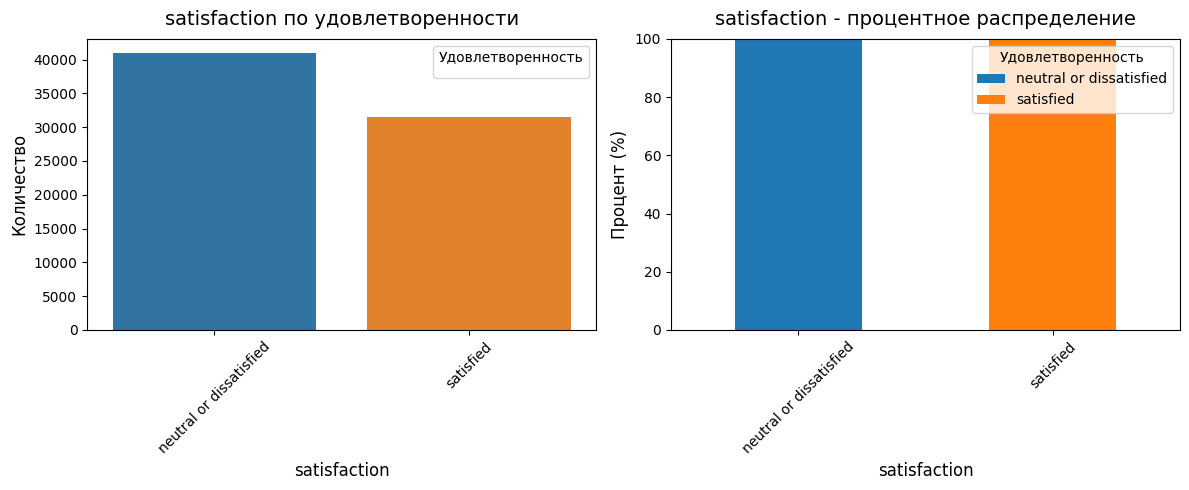

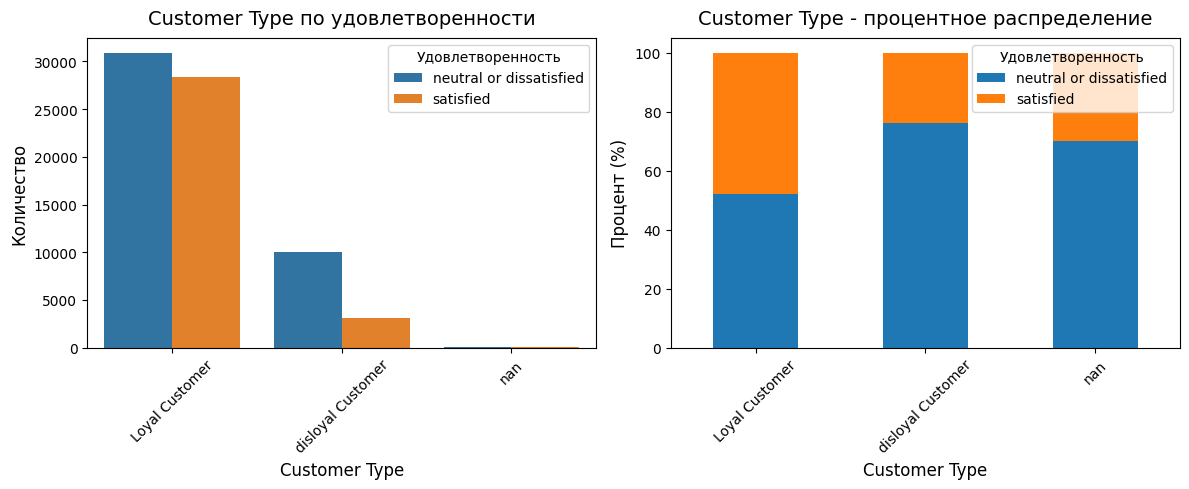

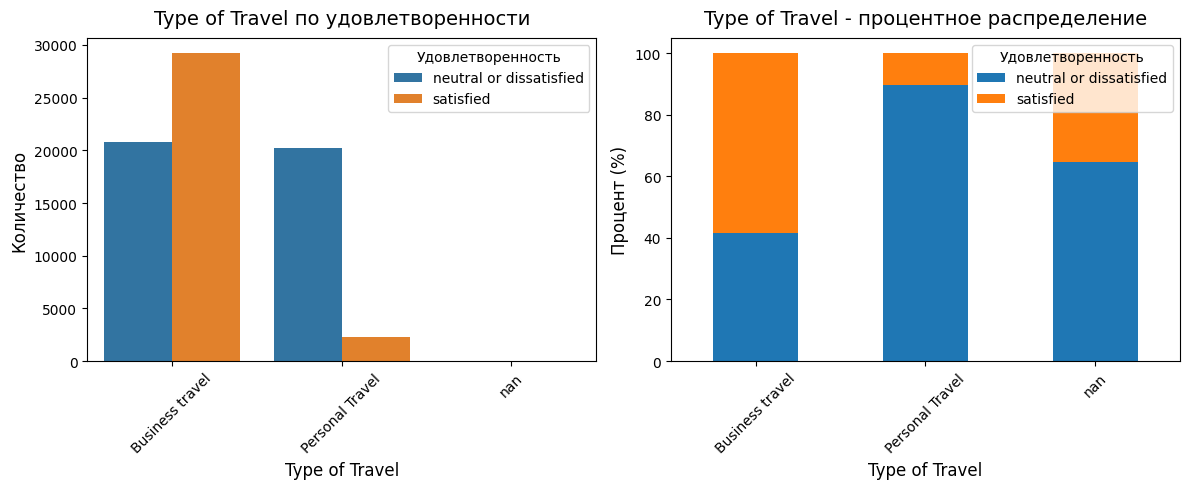

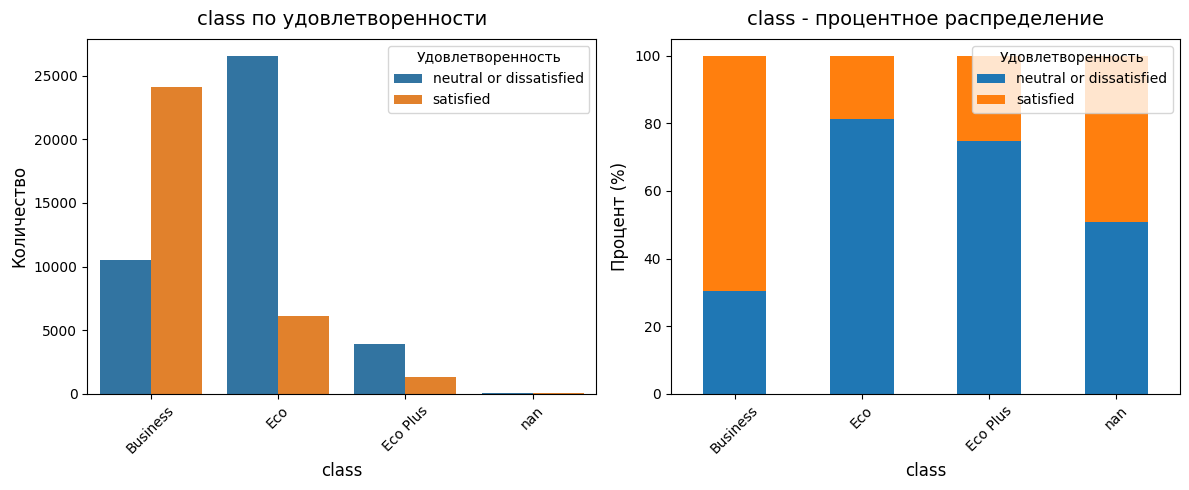

In [88]:
plot_categorical(categorical_cols, X_train, y_train)

/tmp/ipython-input-1300483154.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(boxplot_data, labels=labels)


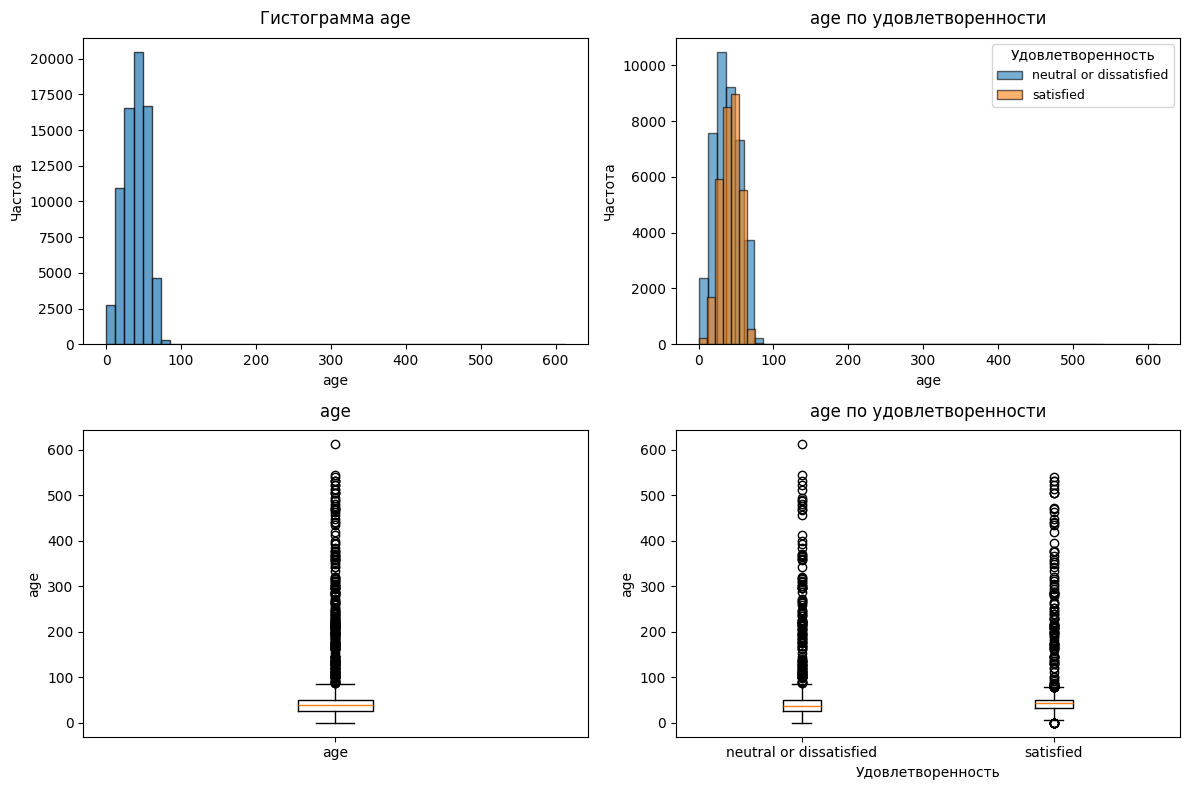

/tmp/ipython-input-1300483154.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(boxplot_data, labels=labels)


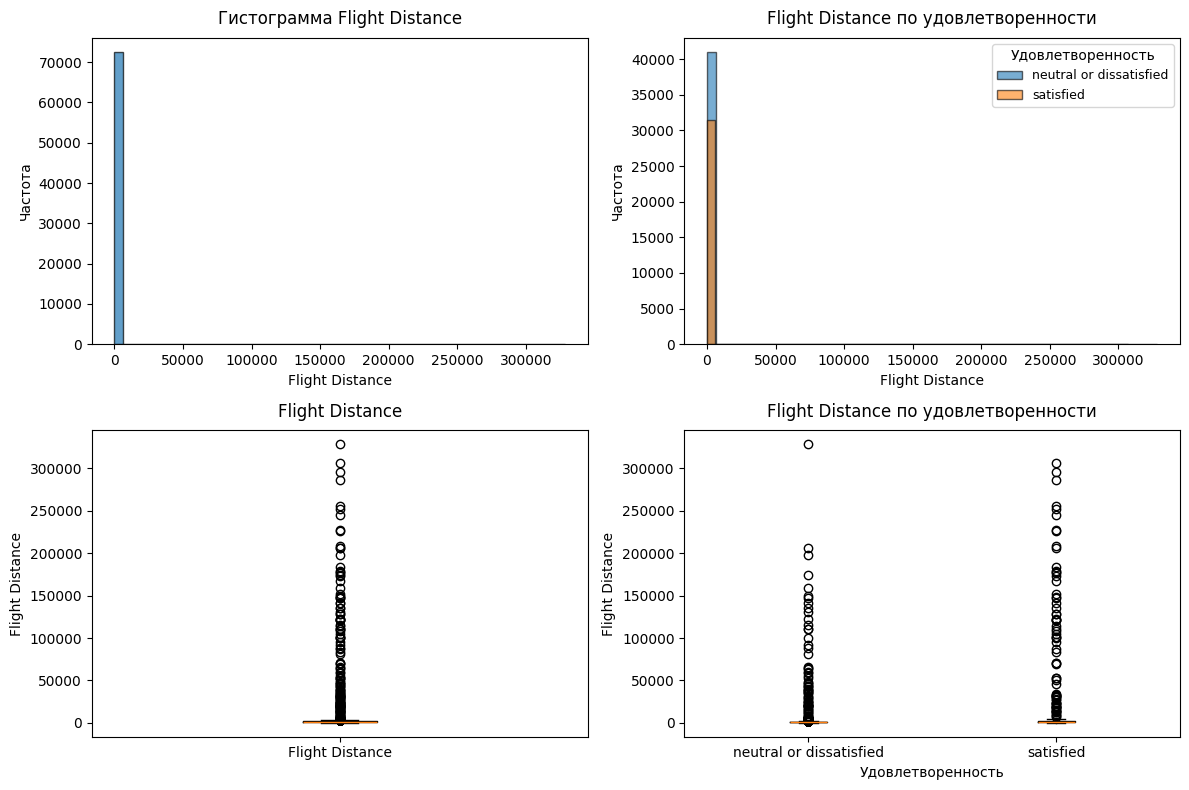

/tmp/ipython-input-1300483154.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(boxplot_data, labels=labels)


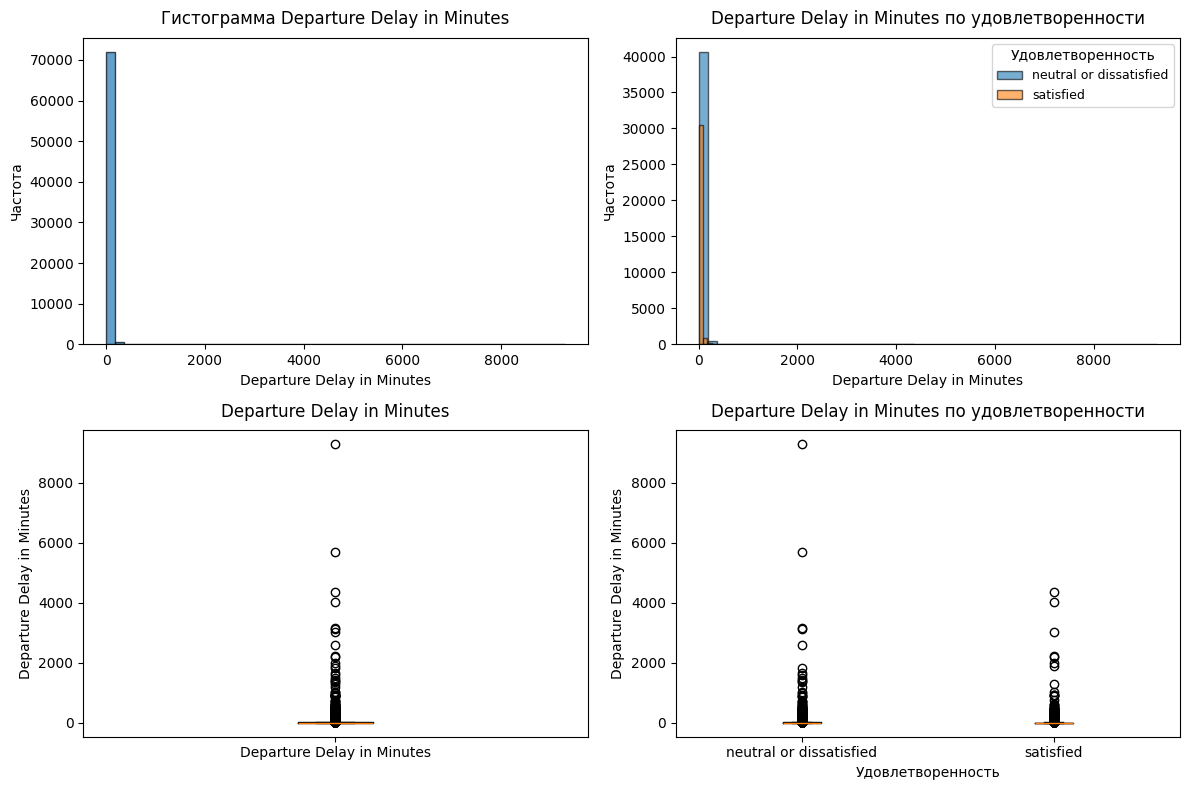

/tmp/ipython-input-1300483154.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(boxplot_data, labels=labels)


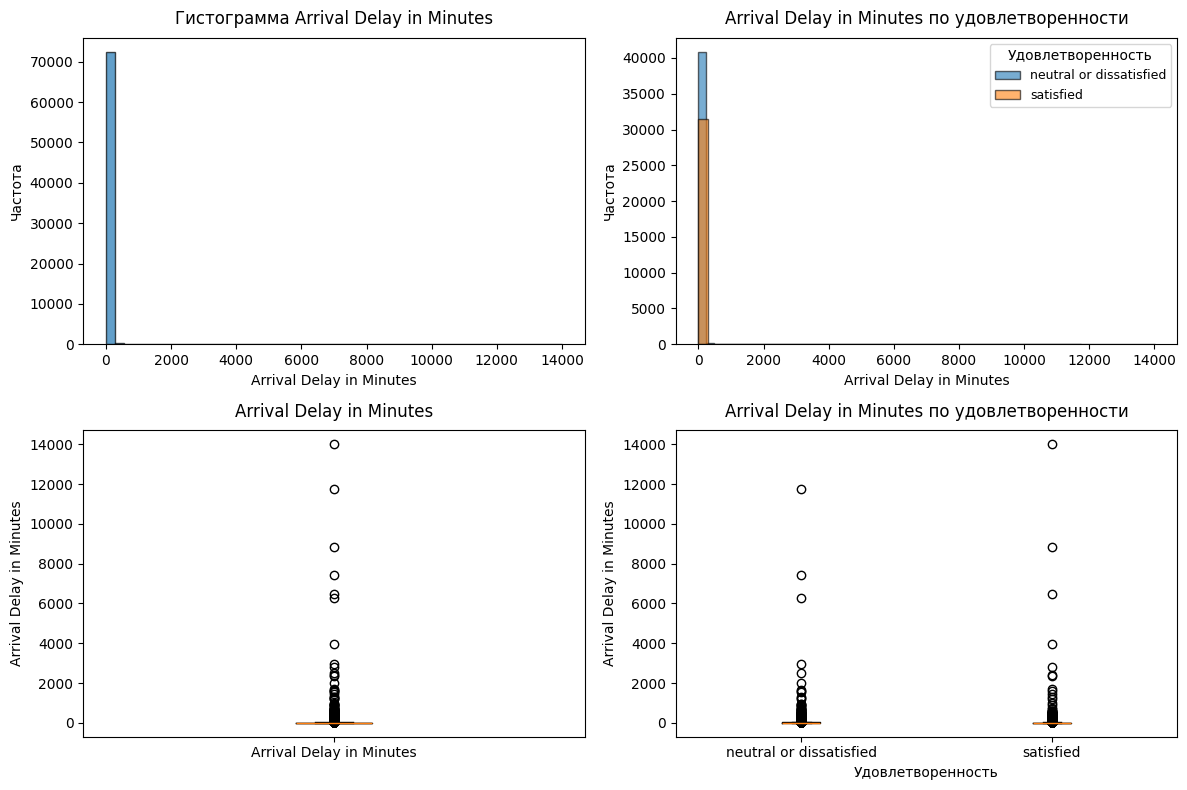

In [61]:
plot_continuous(continuous_cols, X_train, y_train)

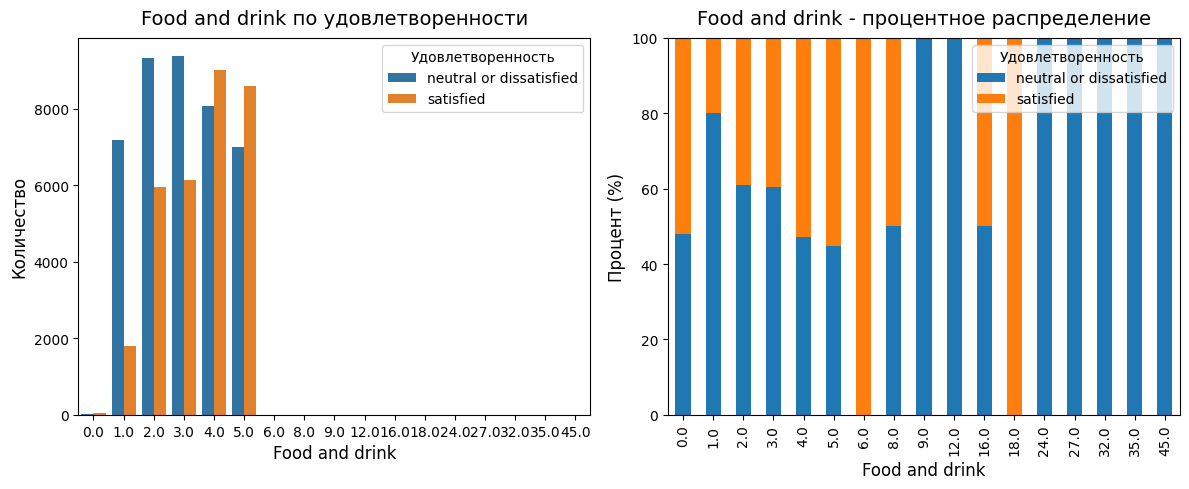

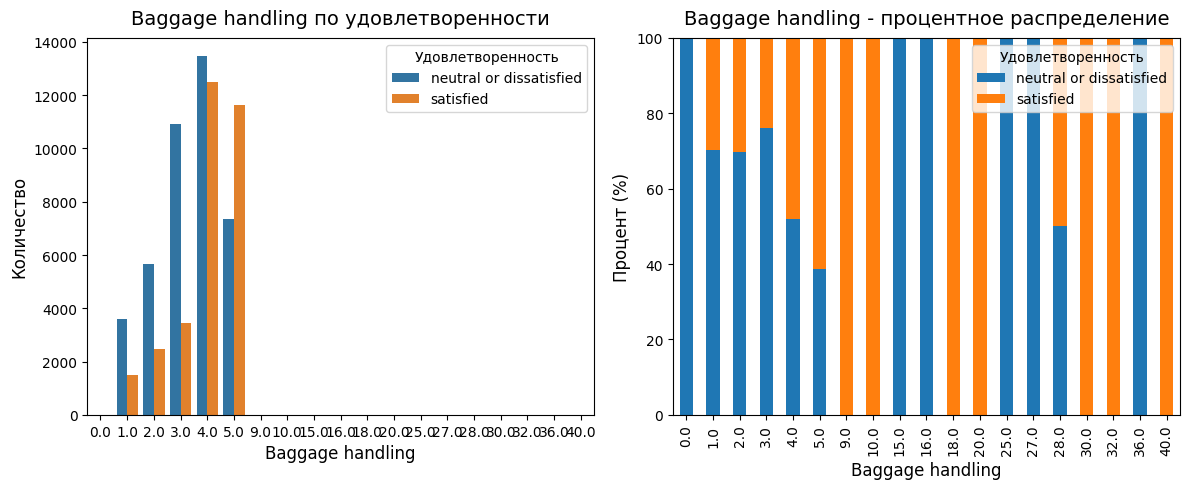

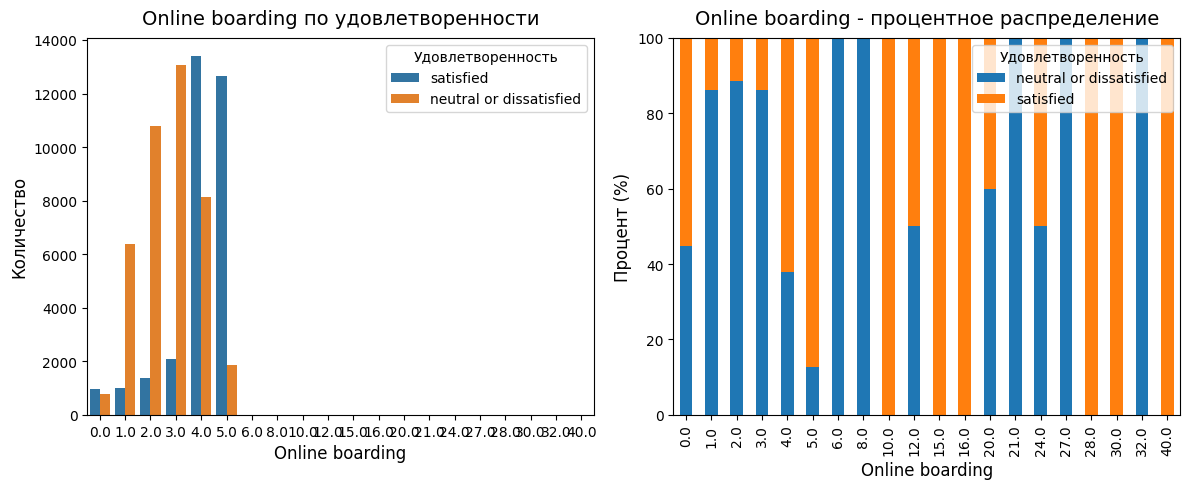

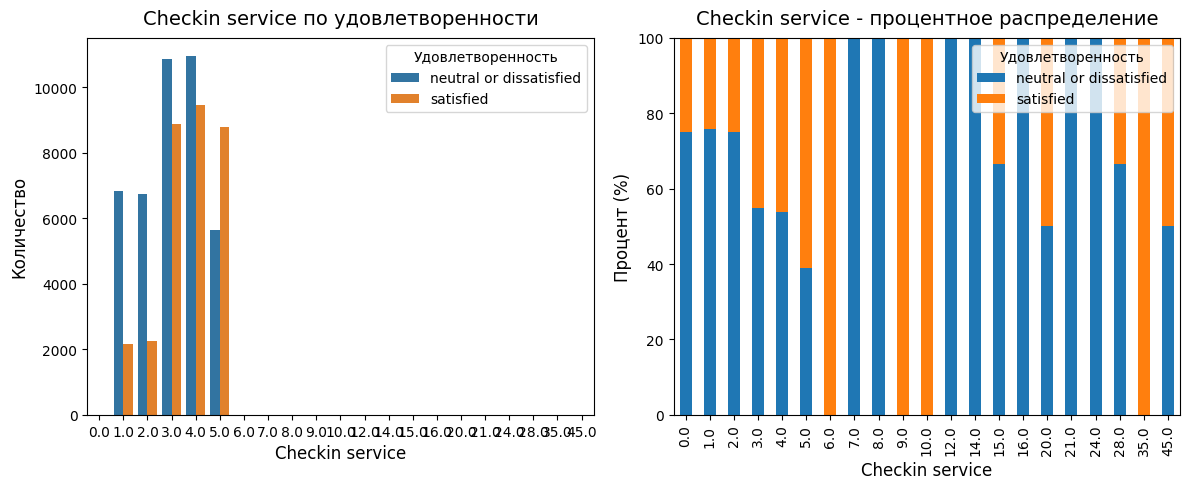

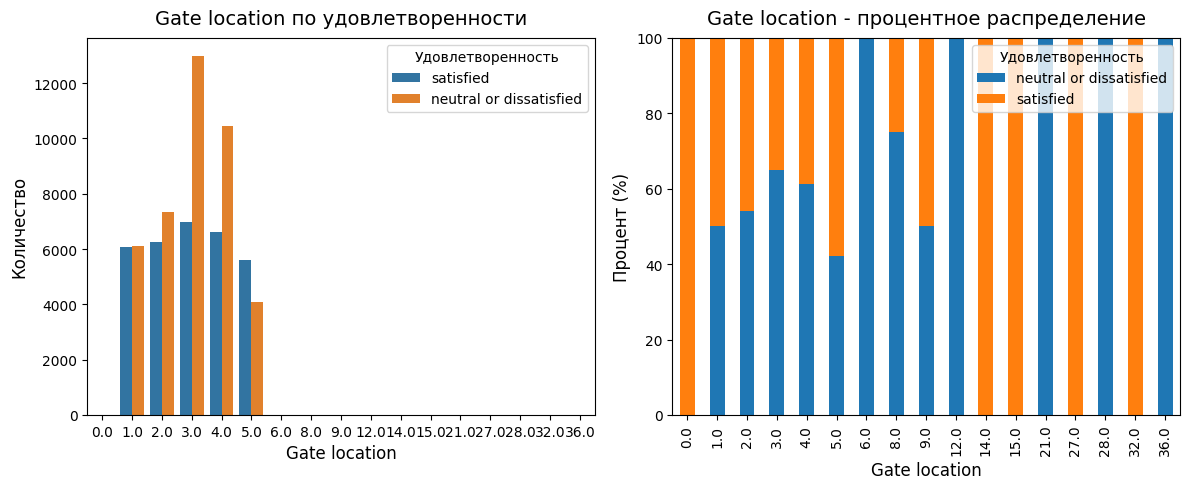

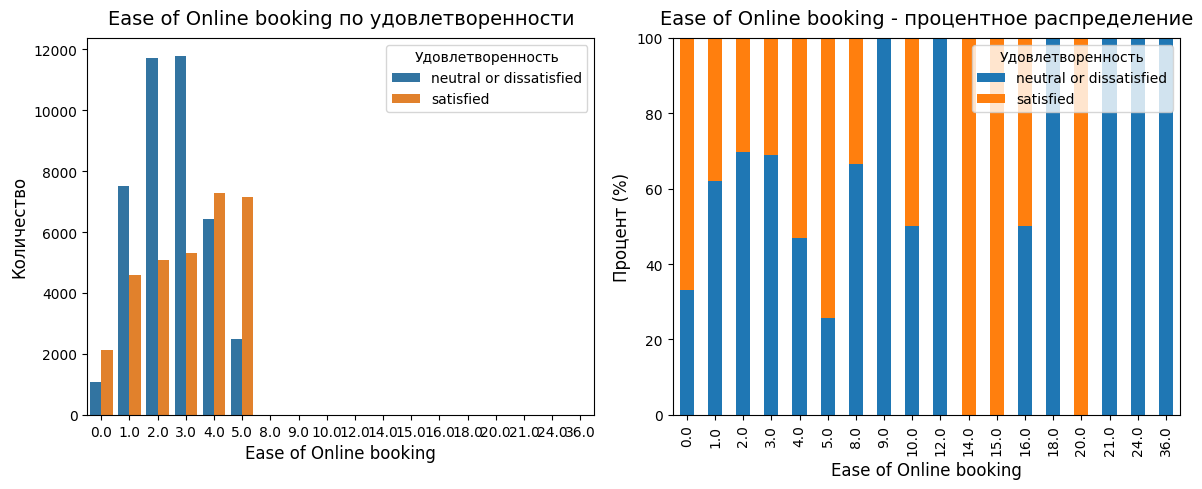

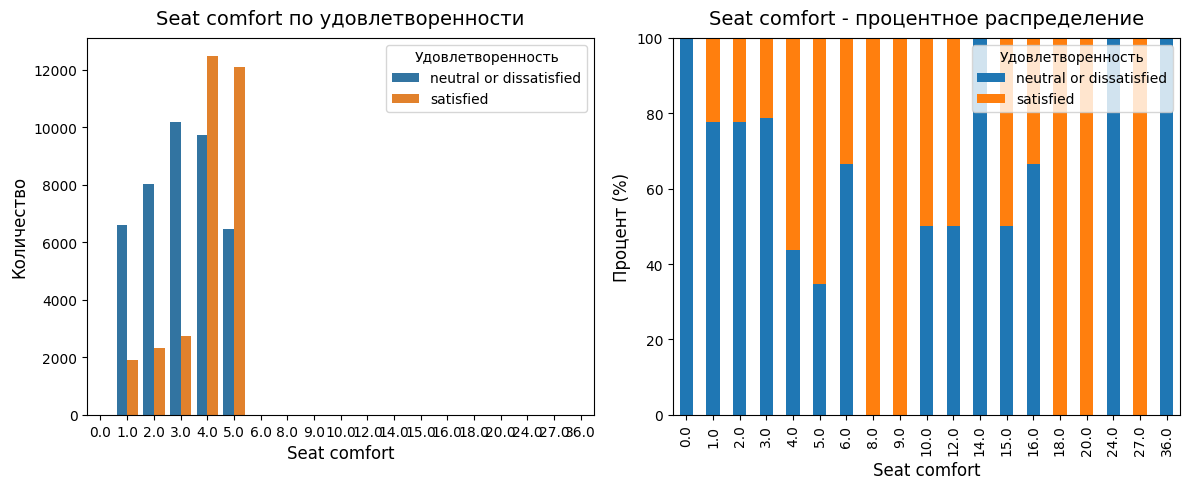

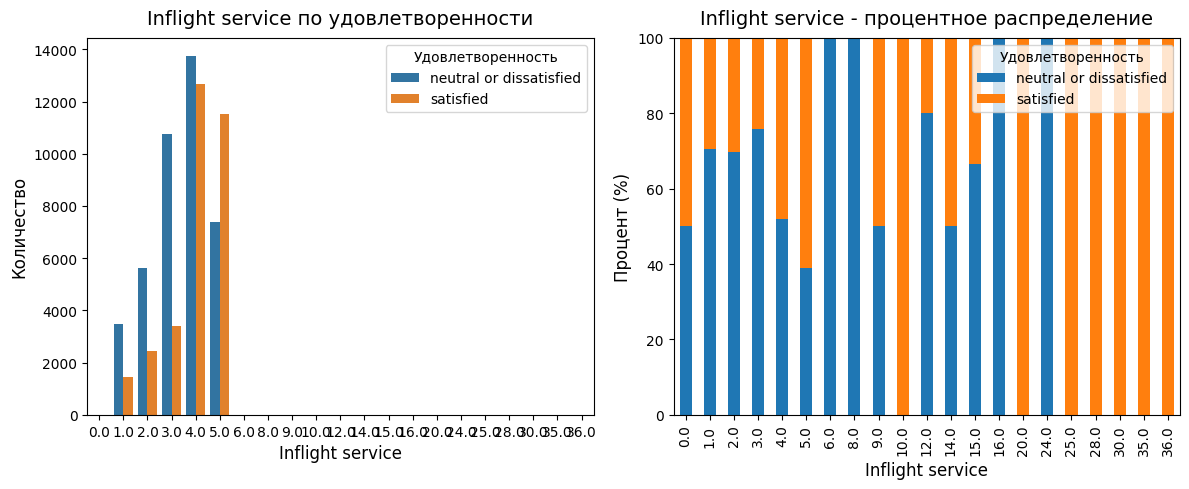

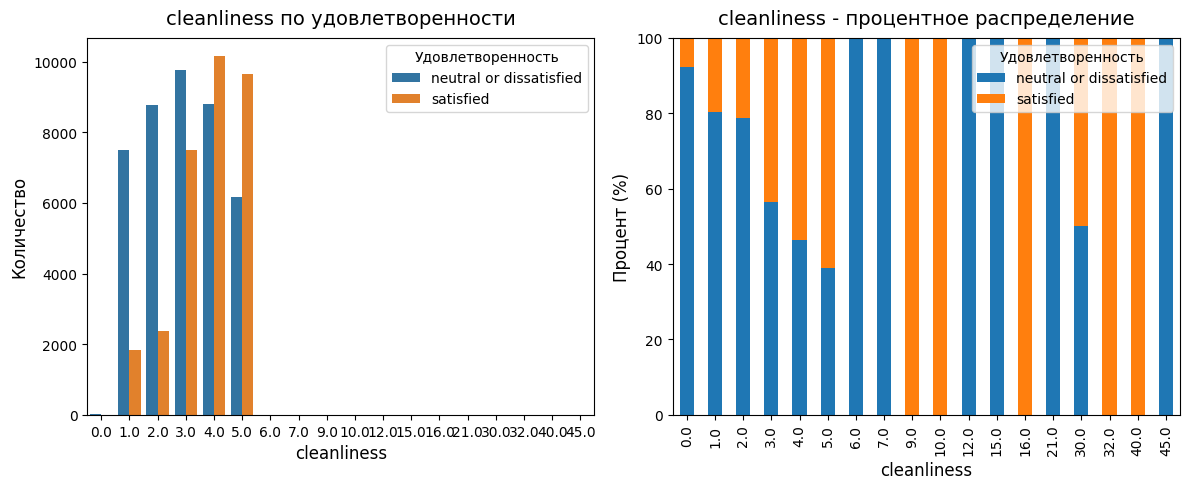

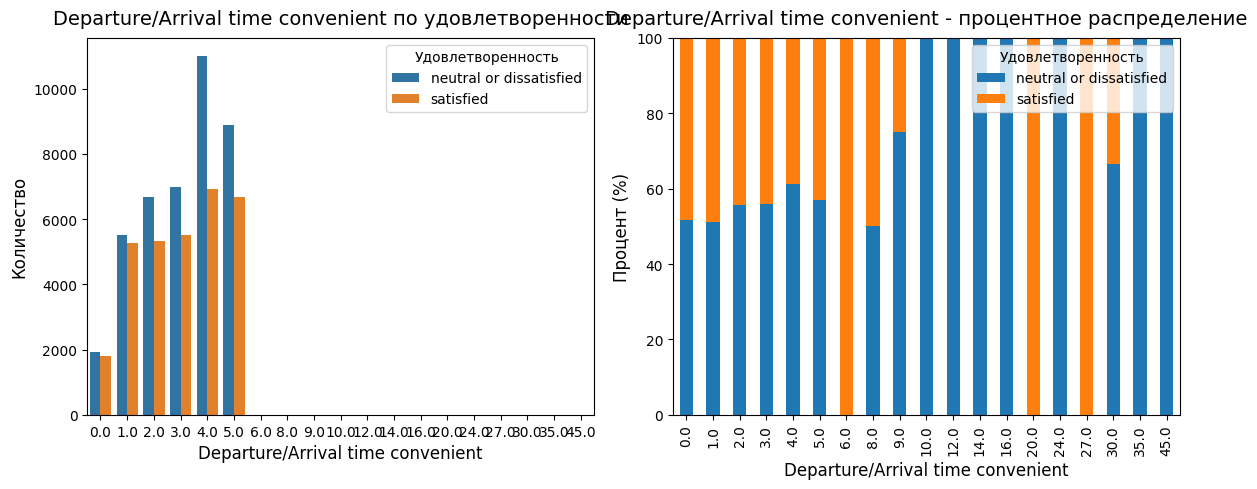

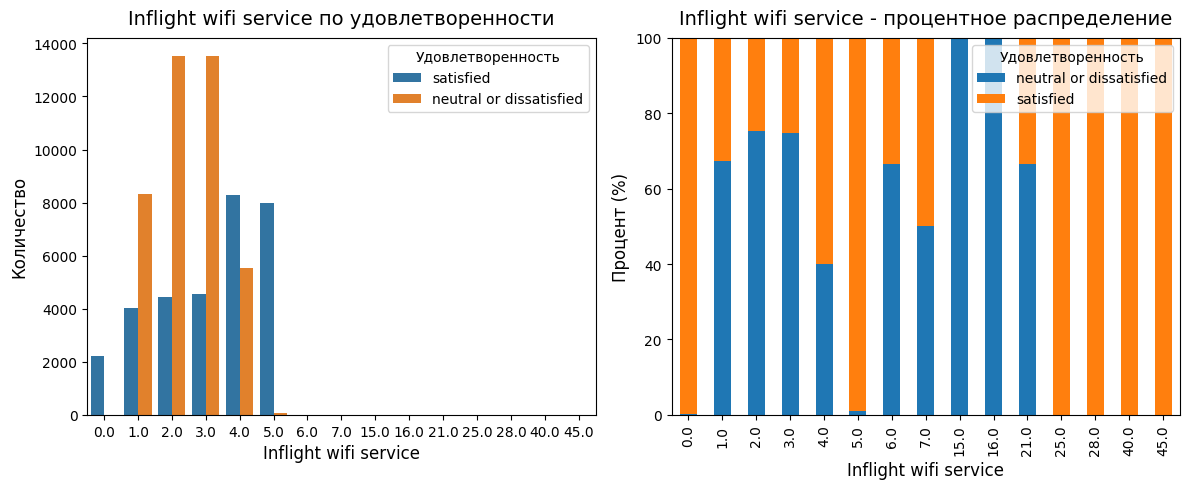

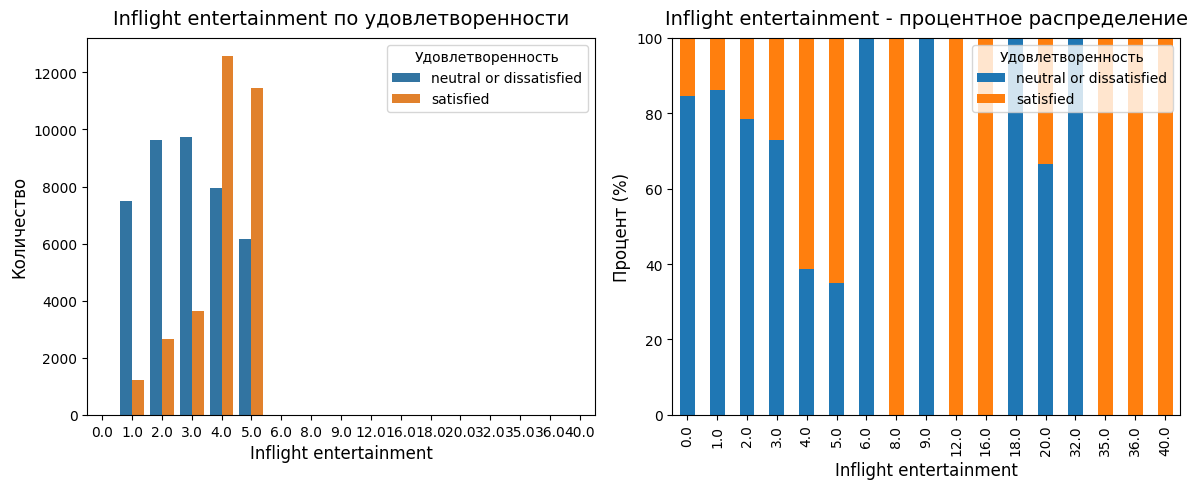

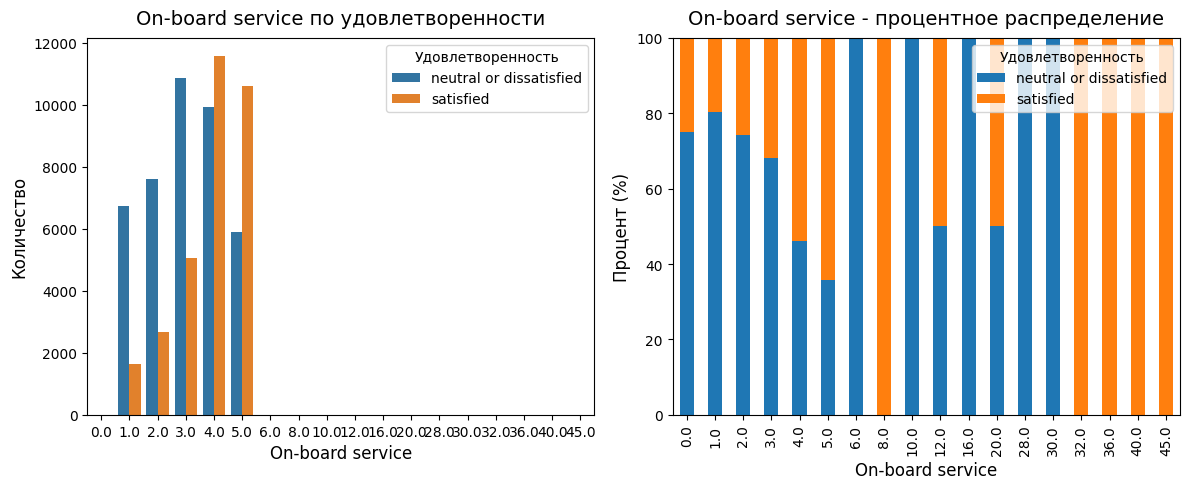

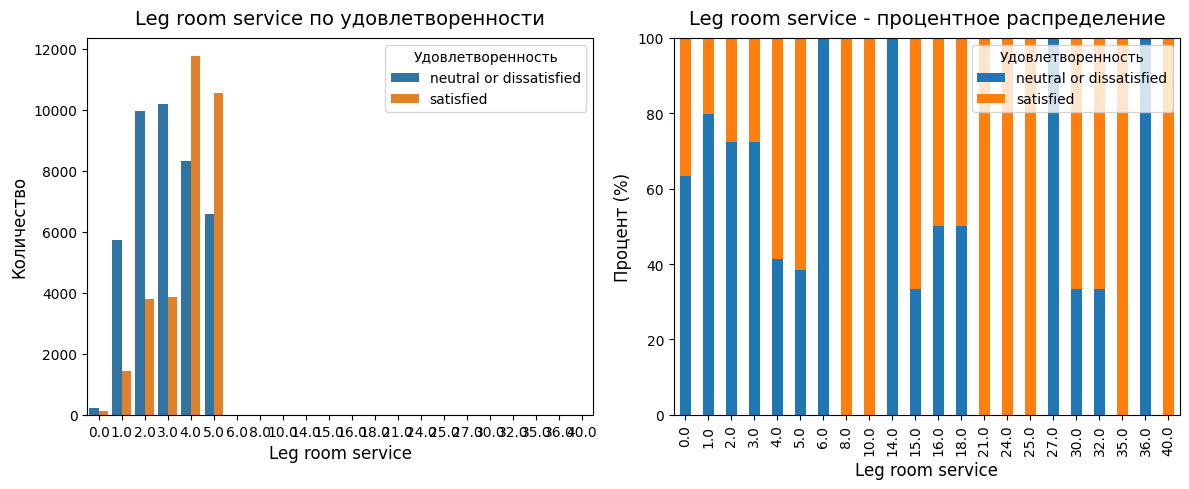

In [56]:
plot_ordinal(ordinal_cols, X_train, y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Ваш ответ здесь
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [ ]:
# Ваш код ниже

X does not have valid feature names, but FunctionTransformer was fitted with feature names


Построение.

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

<Figure size 1440x1440 with 0 Axes>

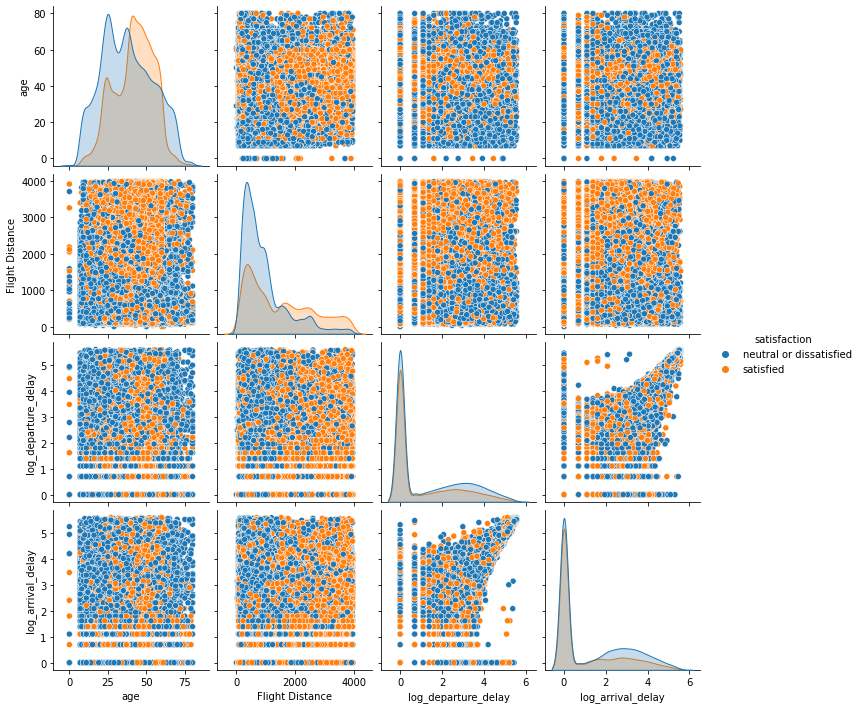

In [ ]:
# Ваш код ниже



# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
# Ваш код ниже

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
# Ваш код ниже

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp
error_dt, bias_dt, var_dt

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
# Ваш код ниже

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

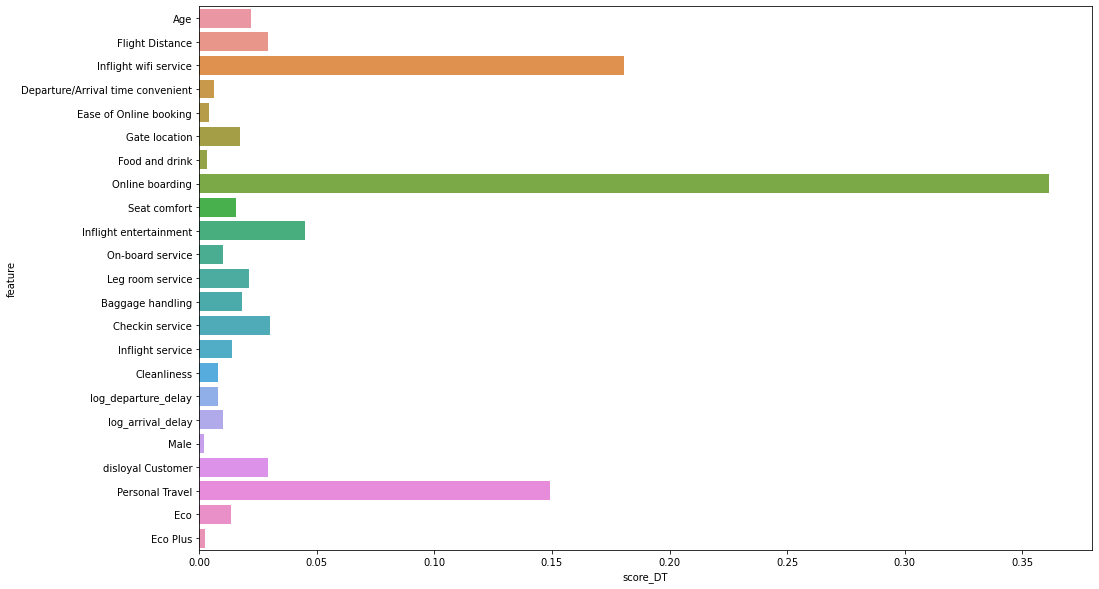

In [ ]:
# Ваш код здесь

`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
# Ваш код здесь

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

In [ ]:
# Ваш код здесь


### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


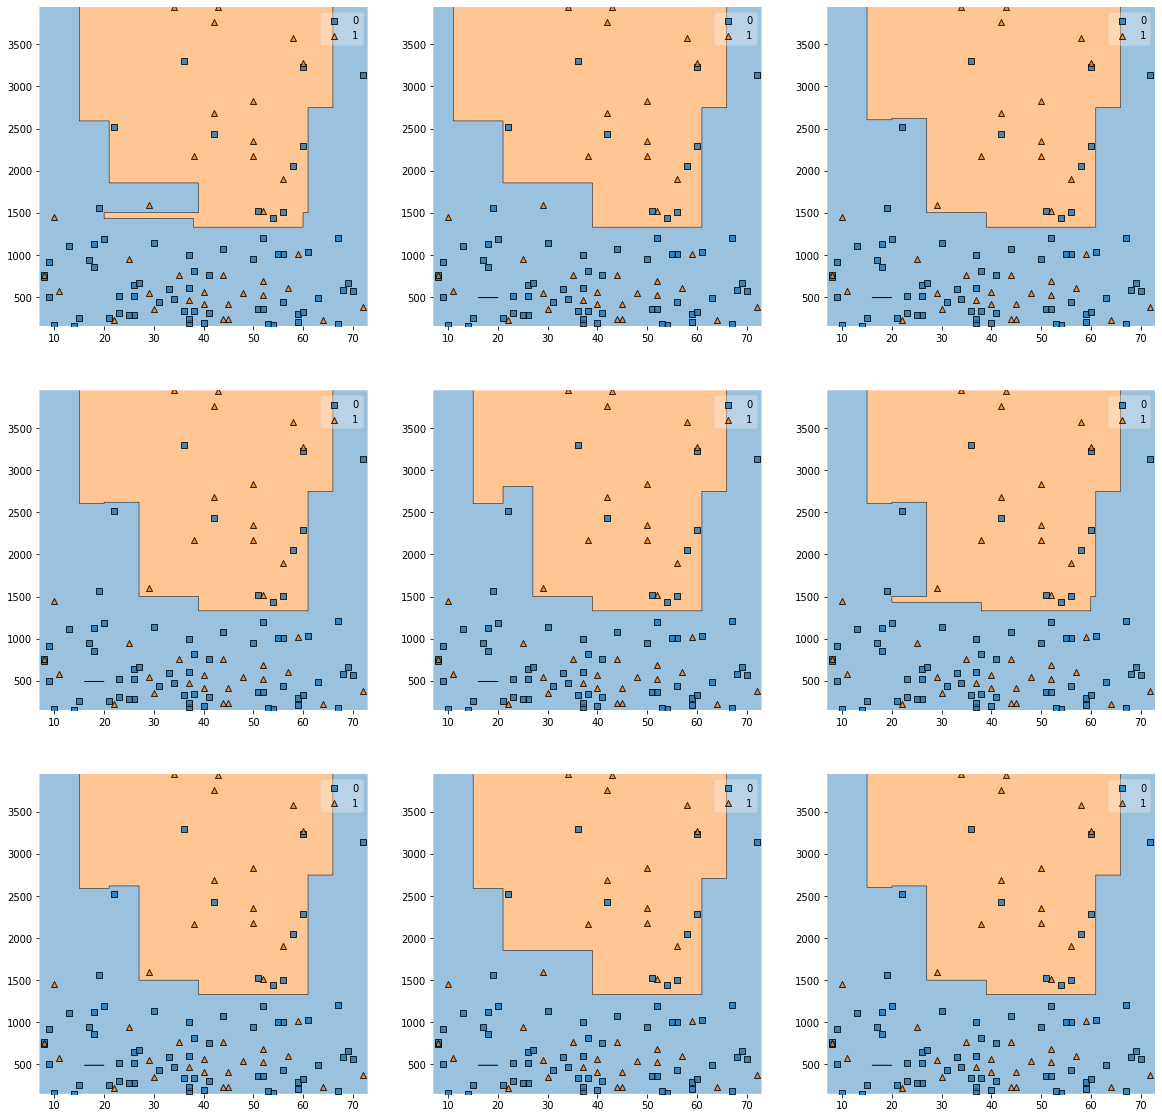

In [ ]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

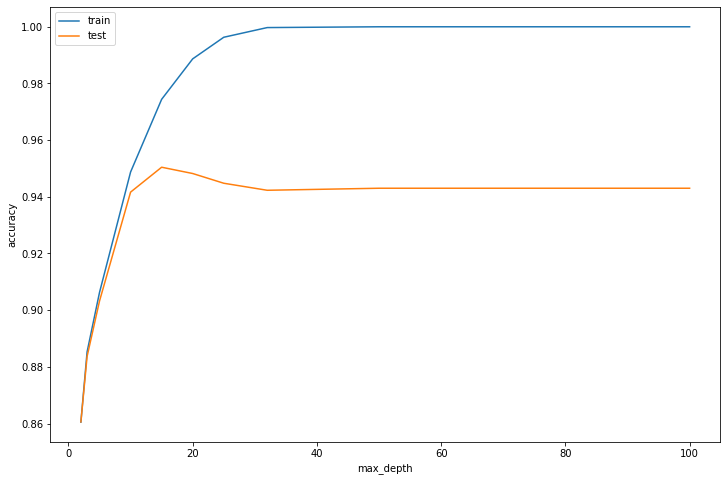

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do



### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

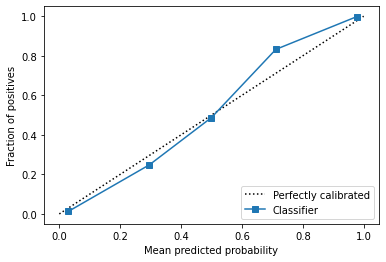

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


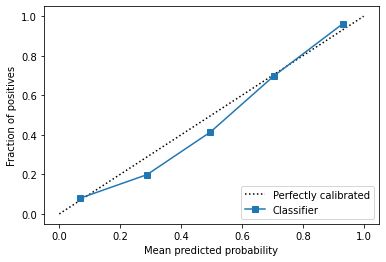

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

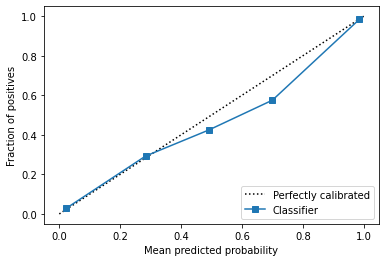

In [ ]:
# Ваш код здесь (Logreg)

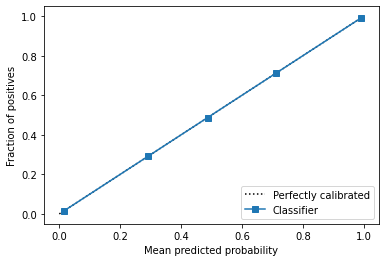

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


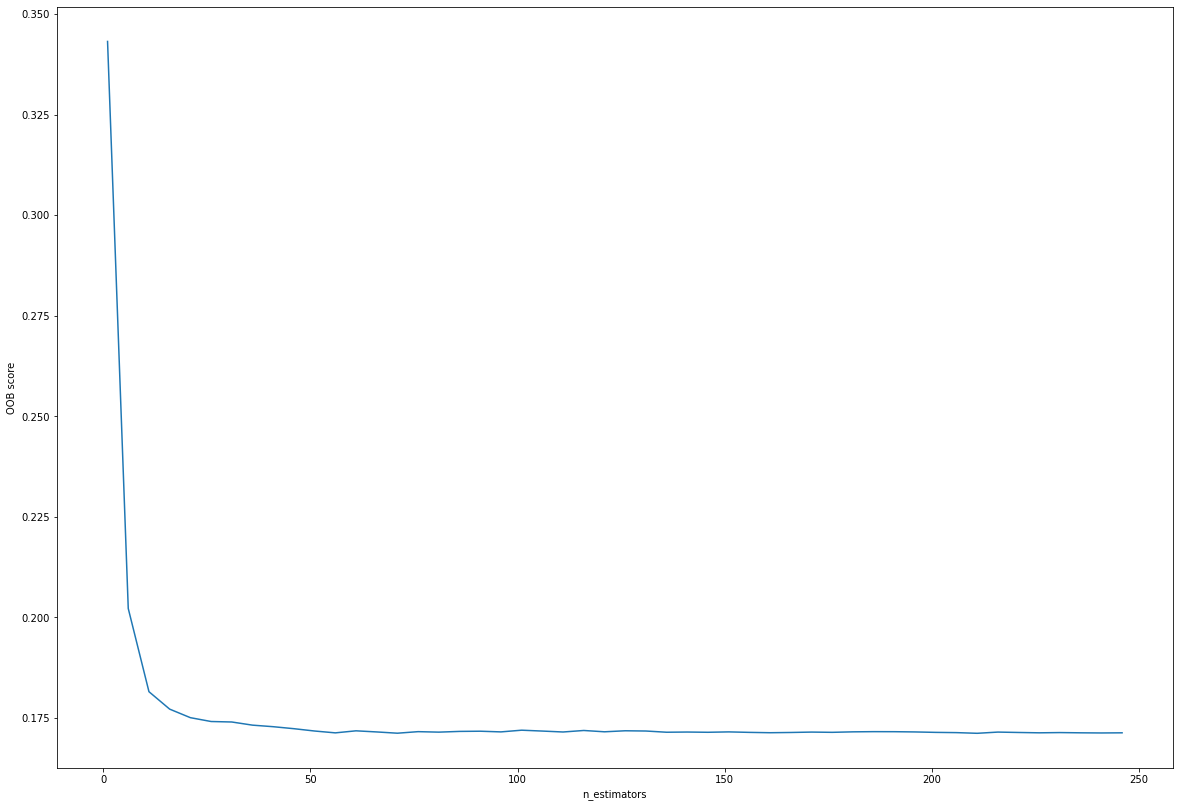

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?